In [26]:
import re
import numpy as np
import pandas as pd
import requests
import librosa
import jiwer
import warnings
import whisper.normalizers
import ptitprince as pt
from scipy import stats
from pathlib import Path
from tqdm.notebook import tqdm
from matplotlib import (
    pyplot as plt,
)

plt.style.use("assets/minimal.mplstyle")
plt.rcParams["figure.dpi"] = 300

warnings.filterwarnings(
    action="ignore",
    category=FutureWarning,
)

class COLORMAP:
    F1_red = "#E10600"

audio_files_path = Path() / "data" / "audio_clips"
text_normalizer = whisper.normalizers.EnglishTextNormalizer()

- ALEALB01_23_20240229_154846 optics > upshift
- LANNOR01_4_20250419_205244 im an f'ing idiot
- MAXVER01_1_20250413_181201 lado > lando
- LANNOR01_4_20240824_122457 landon > lando
- LANNOR01_4_20250906_163307 map > lap
- LANNOR01_4_20241201_113249 can't hear your – strat 10!!!
- MAXVER01_1_20251109_152028 deck > deg(radation)
- ANDANT01_12_20250316_170136 [silence gets transcribed as "thank you"] 
- LIALAW01_30_20250615_151510 peel > PU
- GUAZHO01_24_20240706_113306 upship > upshift
- LANNOR01_4_20240405_034437 landau > Lando
- LANNOR01_4_20240302_153321 lina > Lando

In [27]:
def get_json(url):
    return requests.get(url).json()

radio_messages = pd.merge(
    left=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/team_radio")),
    right=pd.DataFrame.from_records(get_json("https://api.openf1.org/v1/sessions"))[[
        "session_key",
        "location",
        "year",
        "session_name",
    ]],
    on="session_key",
    how="left",
).rename(columns=dict(
    date="timestamp",
)).astype(dict(
    timestamp="datetime64[ns, UTC]",
)).sort_values("timestamp")

radio_messages["identifier"] = radio_messages["recording_url"].str.split("/").str[-1]
radio_messages["file_path"] = (audio_files_path / radio_messages["identifier"]).astype(str)

print(f"Formula 1's API endpoint lists {len(radio_messages)} team radio clips across over {radio_messages["meeting_key"].nunique()} events from {radio_messages["timestamp"].iloc[0].date()} to {radio_messages["timestamp"].iloc[-1].date()}")
radio_messages.tail(3)

Formula 1's API endpoint lists 16420 team radio clips across over 70 events from 2023-03-03 to 2025-12-07


,meeting_key,session_key,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path
16320,1276,9839,4,2025-12-07 14:25:01.949000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_182444.mp3,data/audio_clips/LANNOR01_4_20251207_182444.mp3
16321,1276,9839,4,2025-12-07 14:32:13.730000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,LANNOR01_4_20251207_183123.mp3,data/audio_clips/LANNOR01_4_20251207_183123.mp3
16322,1276,9839,1,2025-12-07 14:33:14.515000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Race,MAXVER01_1_20251207_183223.mp3,data/audio_clips/MAXVER01_1_20251207_183223.mp3


---

In [28]:
def cache_audiofiles(file_path_todo_list):
    for _, radio_message in tqdm(list(file_path_todo_list), smoothing=0):
        if not Path(radio_message["file_path"]).exists():
            try:
                with open(radio_message["file_path"], mode="wb") as file:
                    file.write(requests.get(radio_message["recording_url"]).content)
            except:
                print("Failed on", radio_message["file_path"])

# cache_audiofiles(file_path_todo_list=radio_messages[~radio_messages["file_path"].apply(Path).apply(Path.exists)][["recording_url", "file_path"]].iloc[::-1].iterrows())

Total duration of all 16420 radio messages: 42 hours


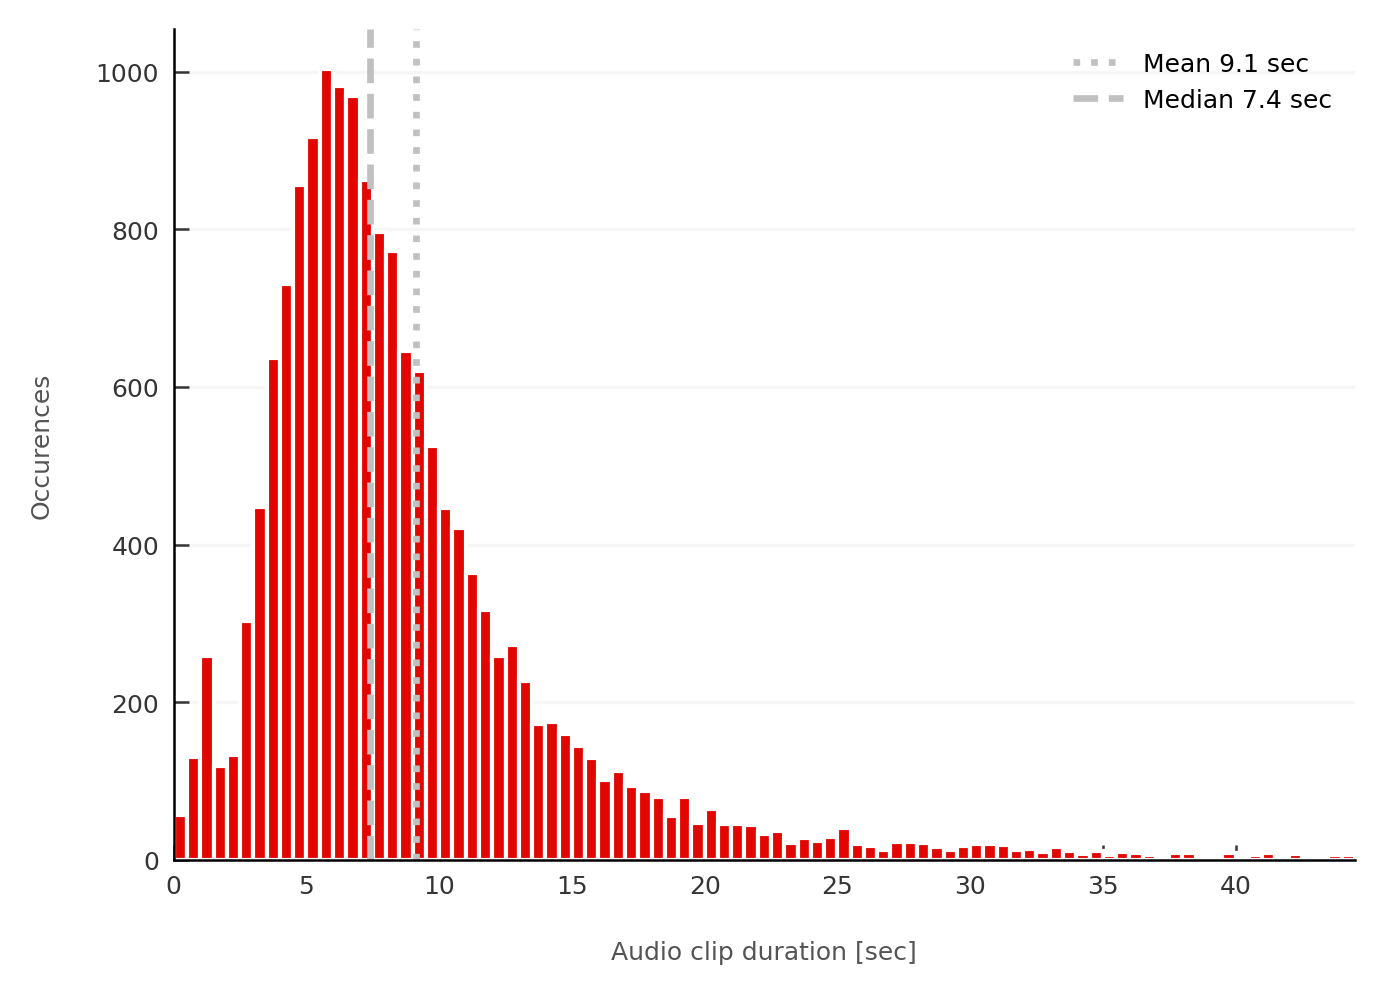

In [29]:
def get_clip_duration(file_path):
    try:
        return librosa.get_duration(path=file_path)
    except:
        return np.nan

if not "clip_duration" in radio_messages.columns:
    radio_messages["clip_duration"] = radio_messages["file_path"].apply(get_clip_duration)
    # radio_messages = radio_messages[radio_messages["clip_duration"] < 30]

print(f"Total duration of all {len(radio_messages)} radio messages: {radio_messages["clip_duration"].sum() / 60 / 60:.0f} hours")

plt.hist(
    radio_messages["clip_duration"],
    bins=np.arange(0, 45, 0.5),
    color=COLORMAP.F1_red,
    edgecolor="white",
    linewidth=1,
)
plt.axvline(
    x=radio_messages["clip_duration"].mean(),
    color="silver",
    linestyle="dotted",
    label=f"Mean {radio_messages["clip_duration"].mean():.1f} sec",
)
plt.axvline(
    x=radio_messages["clip_duration"].median(),
    color="silver",
    linestyle="dashed",
    label=f"Median {radio_messages["clip_duration"].median():.1f} sec",
)
plt.legend(loc="upper right")
plt.xlabel("Audio clip duration [sec]")
plt.ylabel("Occurences")
plt.show()

---

In [30]:
human_labeling_export = pd.read_json(sorted(Path("label-studio/export").iterdir())[-1]).rename(columns=dict(
    transcription="human_transcription",
)).drop_duplicates(
    subset="identifier",
    keep="last",
)

with_human_reference = pd.merge(
    left=radio_messages,
    right=human_labeling_export[[
        "identifier",
        "human_transcription",
        "lead_time",
        "updated_at",
    ]].rename(columns=dict(updated_at="human_transcription_timestamp")),
    on="identifier",
    how="right",
)

with_human_reference = with_human_reference[~with_human_reference["human_transcription"].isna()]

with_human_reference[[
    "identifier",
    "recording_url",
    "file_path",
    "human_transcription",
]].to_json(
    "data/with_human_reference.json", 
    index=False,
    orient="records",
)

print(f"Found {len(with_human_reference.drop_duplicates(subset="identifier"))} radio message clips with human reference, total duration {with_human_reference["clip_duration"].sum() / 60:.0f} minutes")
with_human_reference.sample(3)

Found 755 radio message clips with human reference, total duration 114 minutes


,meeting_key,session_key,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,clip_duration,human_transcription,lead_time,human_transcription_timestamp
178,1213,9112,11,2023-06-30 15:49:32.746000+00:00,https://livetiming.formula1.com/static/2023/20...,Spielberg,2023,Qualifying,SERPER01_11_20230630_164849.mp3,data/audio_clips/SERPER01_11_20230630_164849.mp3,27.576,We've lost that time for track limits. No way;...,NaN,2025-12-07 10:31:30.941685+00:00
265,1268,9912,55,2025-09-07 13:41:26.617000+00:00,https://livetiming.formula1.com/static/2025/20...,Monza,2025,Race,CARSAI01_55_20250907_154059.mp3,data/audio_clips/CARSAI01_55_20250907_154059.mp3,5.904,My front's are dead in traffic.,10.490,2025-12-13 15:54:03.650013+00:00
538,1241,9561,63,2024-07-20 11:22:27.167000+00:00,https://livetiming.formula1.com/static/2024/20...,Budapest,2024,Practice 3,GEORUS01_63_20240720_132200.mp3,data/audio_clips/GEORUS01_63_20240720_132200.mp3,3.384,Tyres are very hot.,4.254,2025-12-13 15:28:53.541163+00:00


---

In [31]:
machine_transcriptions = pd.read_csv(
    "exports/transcriptions.tsv", 
    delimiter="\t",
    names=(
        "transcription_timestamp",
        "identifier",
        "modelidentifier",
        "machine_transcription",
        "avg_logprob",
        "text_nbest",
        "no_speech_prob",
        "temperature",
        "compression_ratio",
        "sum_logprob_nbest",
        "token_nbest",
    ),
).astype(dict(
    transcription_timestamp="datetime64[ns, UTC]",
))

machine_vs_human_transcriptions = pd.merge(
    left=with_human_reference.drop(columns=[
        "meeting_key",
        "session_key",
    ]),
    right=machine_transcriptions,
    on="identifier",
    how="left",
).sort_values("transcription_timestamp").drop_duplicates(
    subset=("identifier", "modelidentifier"),
    keep="first",
)
machine_vs_human_transcriptions = machine_vs_human_transcriptions[~machine_vs_human_transcriptions["machine_transcription"].isna()]

print(f"Found {len(machine_vs_human_transcriptions.drop_duplicates(subset="identifier"))} machine transcribed radio messages that have human transcription, total duration {machine_vs_human_transcriptions.drop_duplicates("identifier")["clip_duration"].sum() / 60:.0f} minutes")
machine_vs_human_transcriptions.tail(3)

Found 755 machine transcribed radio messages that have human transcription, total duration 114 minutes


,driver_number,timestamp,recording_url,location,year,session_name,identifier,file_path,clip_duration,human_transcription,...,transcription_timestamp,modelidentifier,machine_transcription,avg_logprob,text_nbest,no_speech_prob,temperature,compression_ratio,sum_logprob_nbest,token_nbest
1505,81,2025-11-28 14:00:57.564000+00:00,https://livetiming.formula1.com/static/2025/20...,Lusail,2025,Practice 1,OSCPIA01_81_20251128_170037.mp3,data/audio_clips/OSCPIA01_81_20251128_170037.mp3,2.472,Toggle recharge.,...,2025-12-20 17:12:57.817716+00:00,stockWhisper,I'll go recharge.,-0.385654,"['Call the recharge.', 'All the recharge.', ""I...",0.091701,0.0,0.680000,"[-3.835984706878662, -4.117194652557373, -4.43...","[[4889, 262, 27978, 13], [1439, 262, 27978, 13..."
1507,22,2025-12-06 11:24:36.049000+00:00,https://livetiming.formula1.com/static/2025/20...,Yas Island,2025,Practice 3,YUKTSU01_22_20251206_152408.mp3,data/audio_clips/YUKTSU01_22_20251206_152408.mp3,11.808,I had a massive crash. Have you got damage? I...,...,2025-12-20 17:13:00.014415+00:00,stockWhisper,"You got damage? Thank you, sir. I mean, he had...",-0.710052,"['You got damage?', 'You got damage. Thank you...",0.271994,0.0,1.081395,"[-5.9759087562561035, -16.092323303222656, -18...","[[921, 1392, 2465, 30], [921, 1392, 2465, 13, ..."
1509,81,2025-11-29 19:08:13.730000+00:00,https://livetiming.formula1.com/static/2025/20...,Lusail,2025,Qualifying,OSCPIA01_81_20251129_220728.mp3,data/audio_clips/OSCPIA01_81_20251129_220728.mp3,14.520,"So did we get it? Yep, you got it. Just becau...",...,2025-12-20 17:13:03.659632+00:00,stockWhisper,"So is it big in it? Yeah, you got it. Just bec...",-0.335670,"[""So is it big in it? Yeah, you got it. Just b...",0.252824,0.0,1.293233,"[-15.802191734313965, -17.14323616027832, -17....","[[1406, 318, 340, 1263, 287, 340, 30, 9425, 11..."


In [32]:
machine_vs_human_transcriptions[["identifier", "modelidentifier", "machine_transcription", "human_transcription"]].sort_values(["identifier", "modelidentifier"]).pivot(
    index=["identifier", "human_transcription"], 
    columns="modelidentifier",
    values="machine_transcription",
)

,modelidentifier,TCPGenWhisper,stockWhisper
identifier,human_transcription,,
ALEALB01_23_20230303_154119.mp3,"What do you think on the front wing, Alex? It feels quite low, but I'll have to leave it. For this tire it's good.",Do you Ryo think of the front wing on it? It f...,Do you think of the front wing on it? It feels...
ALEALB01_23_20230304_121554.mp3,,you,you
ALEALB01_23_20230304_121558.mp3,"Yeah, that was all wrong. Massive front-locking and just understeer through that whole stint from ... from turn-in turn one to the final corner.","Here, that was q1. It was massive, I'm knockin...","Here, that was all your... It's massive. I'm k..."
ALEALB01_23_20230630_125731.mp3,"So, feedback on gears. So, turn 1, shifting on the kerbs, try to avoid that if you can. Yeah, well, that's how it is. Yeah. Yeah. Yeah, understood.",So feedback on gears. So turn one shifting on ...,"So, feedback on gears. So, turn one, shifting ..."
ALEALB01_23_20230701_110330.mp3,OK. This is a good gap to de Vries ahead. So let's try and stay ahead of Alonso. Alonso 2.5.,"Okay, this is a good gap to the frees ahead, s...","Okay, this is a good gap from the freezer head..."
...,...,...,...
YUKTSU01_22_20250802_133133.mp3,What a session!,They brought a session.,It was a session.
YUKTSU01_22_20251121_165021.mp3,"Yuki, we're going to box this lap, box this lap. We've got an issue with the car, so we're going to box this lap.","Here we go, we're going to box this lap, box t...","Here we're going to box this lap, box this lap..."
YUKTSU01_22_20251122_203037.mp3,,you,you


---

<!-- ln -s radio_messages/ /home/ucloud/.local/share/label-studio/radio_messages -->

In [33]:
for metric, estimator in [
    ("WER", jiwer.wer),
    ("WIP", jiwer.wip),
]:
    machine_vs_human_transcriptions[metric] = machine_vs_human_transcriptions.apply(lambda radio_message: estimator(
        text_normalizer(radio_message["machine_transcription"]),
        text_normalizer(radio_message["human_transcription"]),
    ), axis=1)


## WER stats

In [34]:
machine_vs_human_transcriptions.groupby("modelidentifier")["WER"].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
modelidentifier,,,,,,,,
TCPGenWhisper,755.0,0.828,1.586,0.0,0.240,0.462,0.928,22.0
stockWhisper,755.0,0.548,0.998,0.0,0.173,0.333,0.691,22.0


In [35]:
stock_transcriptions = machine_vs_human_transcriptions[machine_vs_human_transcriptions["modelidentifier"] == "stockWhisper"]
TCPGen_transcriptions = machine_vs_human_transcriptions[machine_vs_human_transcriptions["modelidentifier"] == "TCPGenWhisper"]

In [36]:
stats.ttest_ind(
    stock_transcriptions["WER"],
    TCPGen_transcriptions["WER"],
    equal_var=False,
)

TtestResult(statistic=np.float64(-4.110066627208858), pvalue=np.float64(4.209022786290971e-05), df=np.float64(1270.3852748554843))

## WIP stats

In [37]:
machine_vs_human_transcriptions.groupby("modelidentifier")["WIP"].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
modelidentifier,,,,,,,,
TCPGenWhisper,755.0,0.441,0.296,0.0,0.185,0.463,0.681,1.0
stockWhisper,755.0,0.511,0.308,0.0,0.257,0.538,0.759,1.0


In [38]:
stats.ttest_ind(
    stock_transcriptions["WIP"],
    TCPGen_transcriptions["WIP"],
    equal_var=False,
)

TtestResult(statistic=np.float64(4.478486502967233), pvalue=np.float64(8.08437254098125e-06), df=np.float64(1505.544767259815))

NameError: name 'ticker' is not defined

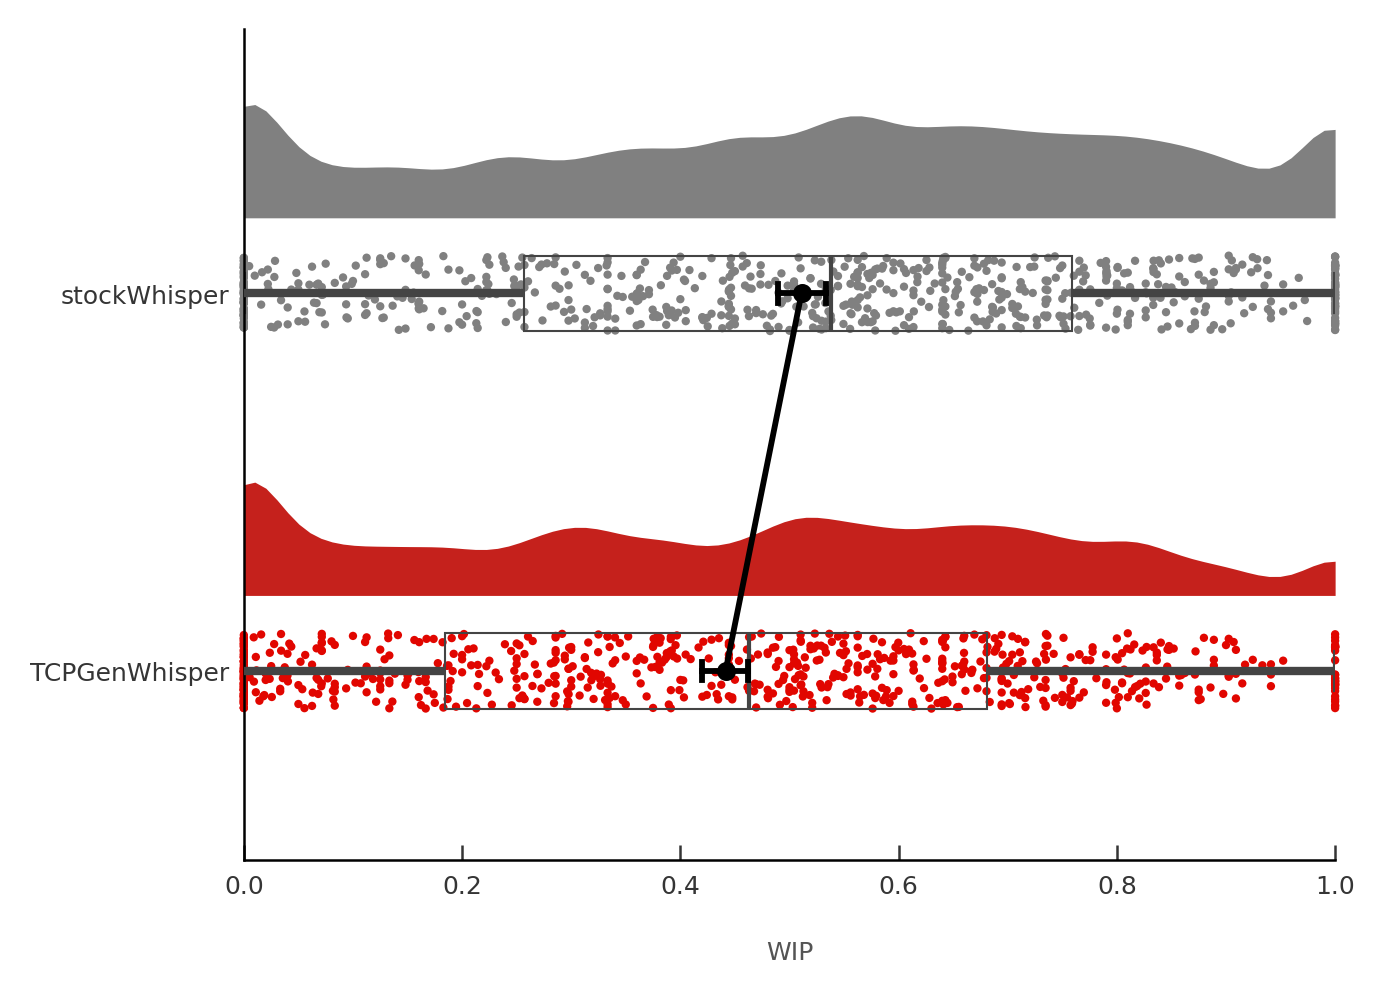

In [39]:
fig, ax = plt.subplots()
ax = pt.RainCloud(
    data=machine_vs_human_transcriptions,
    x="modelidentifier",
    y="WIP",
    hue="modelidentifier",
    order=sorted(machine_vs_human_transcriptions["modelidentifier"].unique(), reverse=True),
    bw=0.1,
    palette=(
        COLORMAP.F1_red,
        "grey",
    ),
    width_viol=0.6,
    width_box=0.2,
    linewidth=0,
    alpha=1,
    point_size=2,
    orient="h",
    rain_clip_on=False,
    pointplot=True,
    linecolor="black",
    point_linewidth=1.4,
    point_errorbar="ci",
    point_errwidth=1.4,
    point_capsize=0.05,
    ax=ax, 
)
plt.ylabel("")
plt.xlabel("WIP")
plt.xlim(0, 1)
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.show()

fig.savefig(Path() / "exports" / "raincloud_plot_wip_comparison.png")

In [ ]:
with open("data/biasing_list.txt") as file:
    biasing_terms = [word.strip() for word in file]

def biasing_terms_in_utterance(utterance):
    words = [re.sub(r"[^A-Za-z0-9 *]", "", word).strip().upper() for word in utterance.upper().split()]
    return list(set([word for word in words if word in biasing_terms]))

machine_vs_human_transcriptions["biasing_terms"] = machine_vs_human_transcriptions["human_transcription"].apply(biasing_terms_in_utterance)

machine_vs_human_transcriptions[machine_vs_human_transcriptions["biasing_terms"].apply(len) > 0].groupby("modelidentifier")["WIP"].describe().round(3)

,count,mean,std,min,25%,50%,75%,max
modelidentifier,,,,,,,,
TCPGenWhisper,580.0,0.453,0.285,0.0,0.214,0.489,0.681,1.0
stockWhisper,580.0,0.528,0.297,0.0,0.298,0.562,0.766,1.0


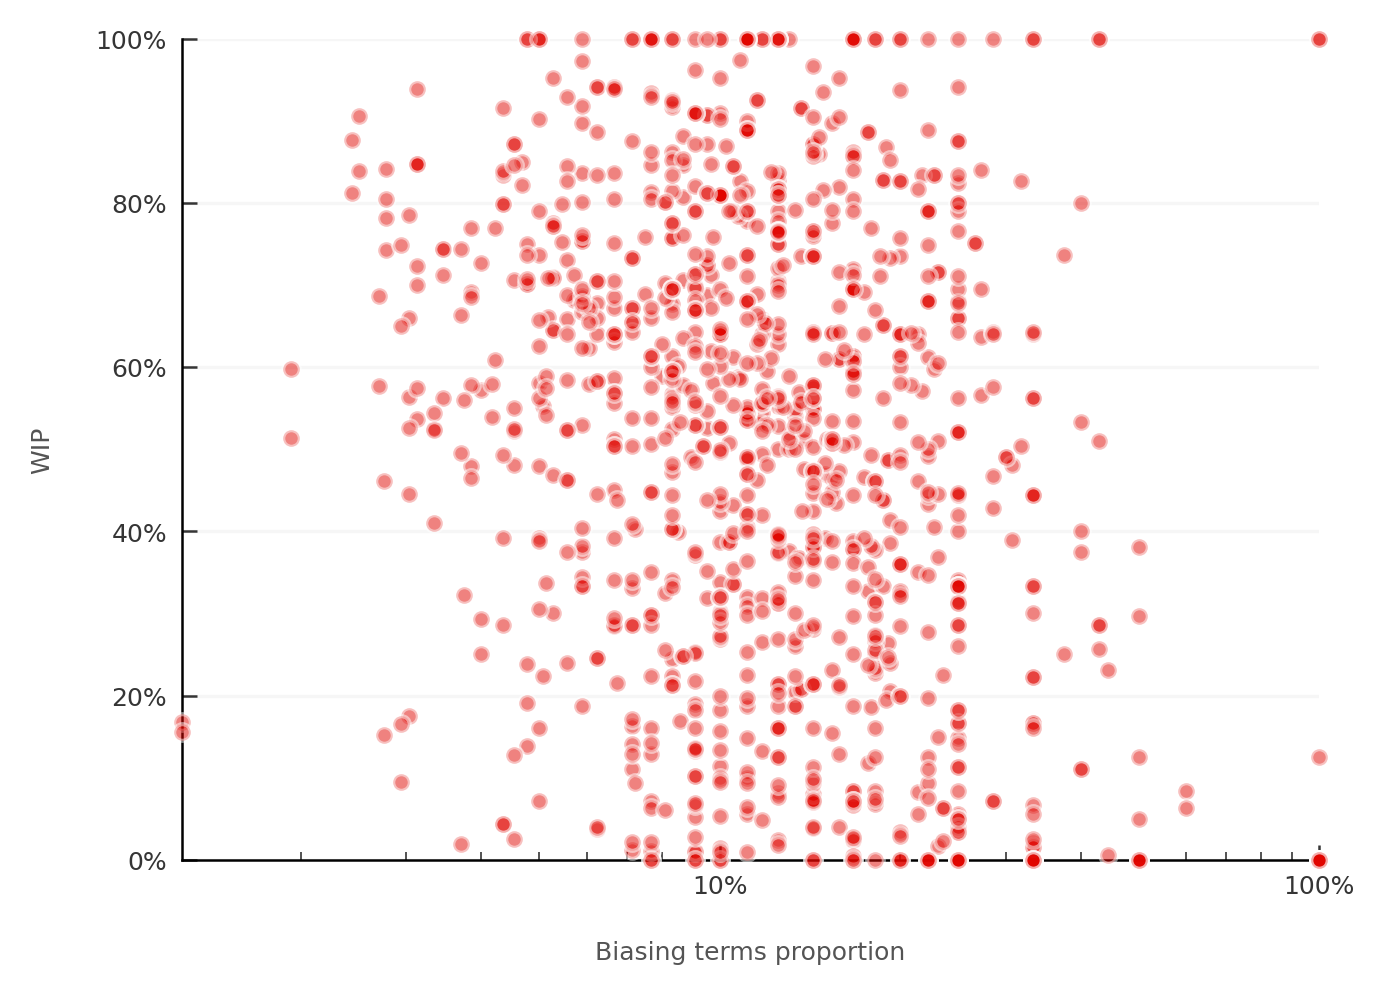

In [ ]:
plt.scatter(
    machine_vs_human_transcriptions["biasing_terms"].apply(len) / machine_vs_human_transcriptions["human_transcription"].str.split().str.len(),
    machine_vs_human_transcriptions["WIP"],
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1))
# plt.xlim(right=1)
plt.ylim(0, 1)
plt.xlabel("Biasing terms proportion")
plt.ylabel("WIP")
plt.show()

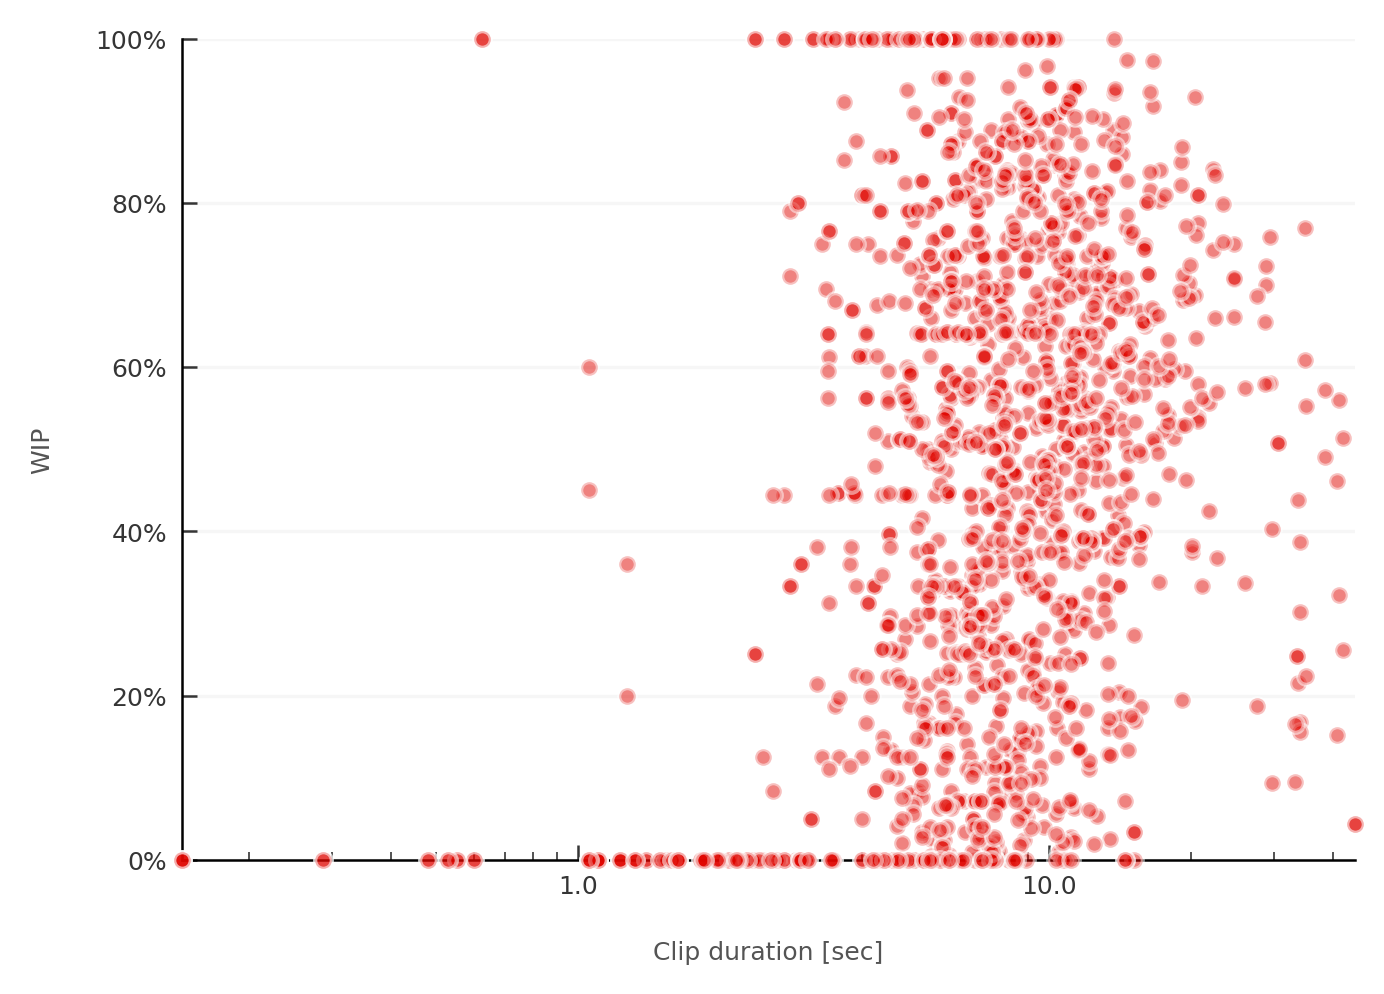

In [ ]:
plt.scatter(
    machine_vs_human_transcriptions["clip_duration"],
    machine_vs_human_transcriptions["WIP"],
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.xscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.ylim(0, 1)
plt.xlabel("Clip duration [sec]")
plt.ylabel("WIP")
plt.show()

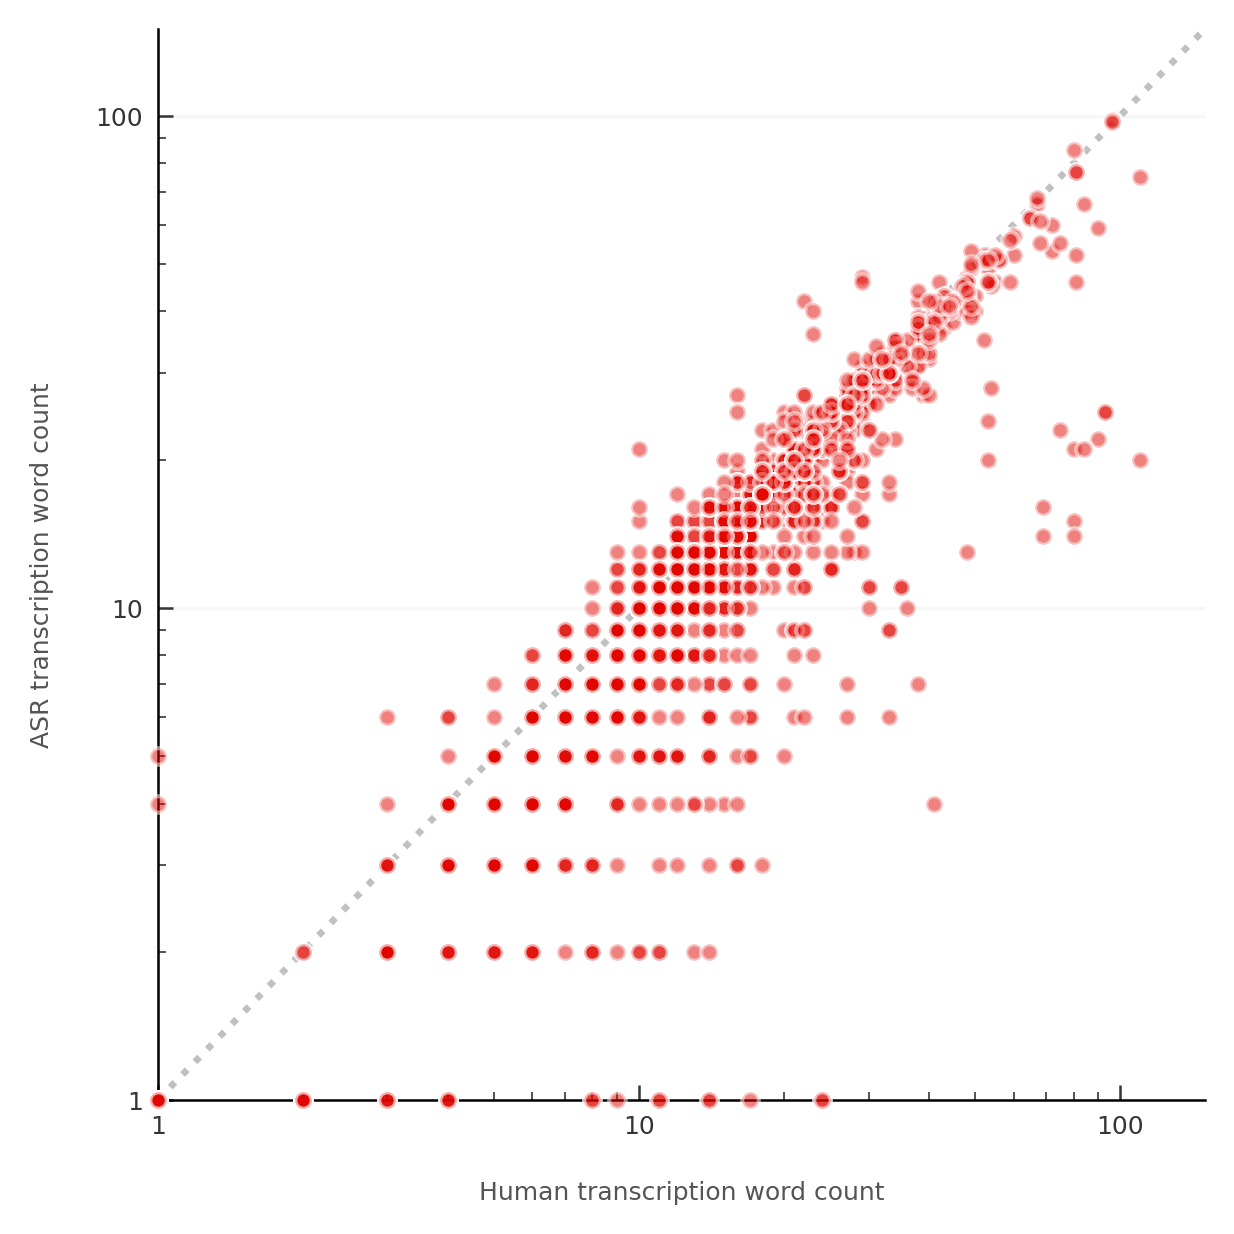

In [ ]:
plt.figure(figsize=(4, 4))
plt.scatter(
    machine_vs_human_transcriptions["human_transcription"].str.split(" ").str.len(),
    machine_vs_human_transcriptions["machine_transcription"].str.split(" ").str.len(),
    color=COLORMAP.F1_red,
    edgecolor="white",
    alpha=0.5,
    clip_on=False,
    zorder=5,
)
plt.plot(
    [0, 1],
    [0, 1],
    transform=plt.gca().transAxes,
    color="silver",
    linestyle="dotted",
    zorder=-1,
)
plt.xscale("log", base=10)
plt.yscale("log", base=10)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlim(1, 150)
plt.ylim(1, 150)
plt.xlabel("Human transcription word count")
plt.ylabel("ASR transcription word count")
plt.show()

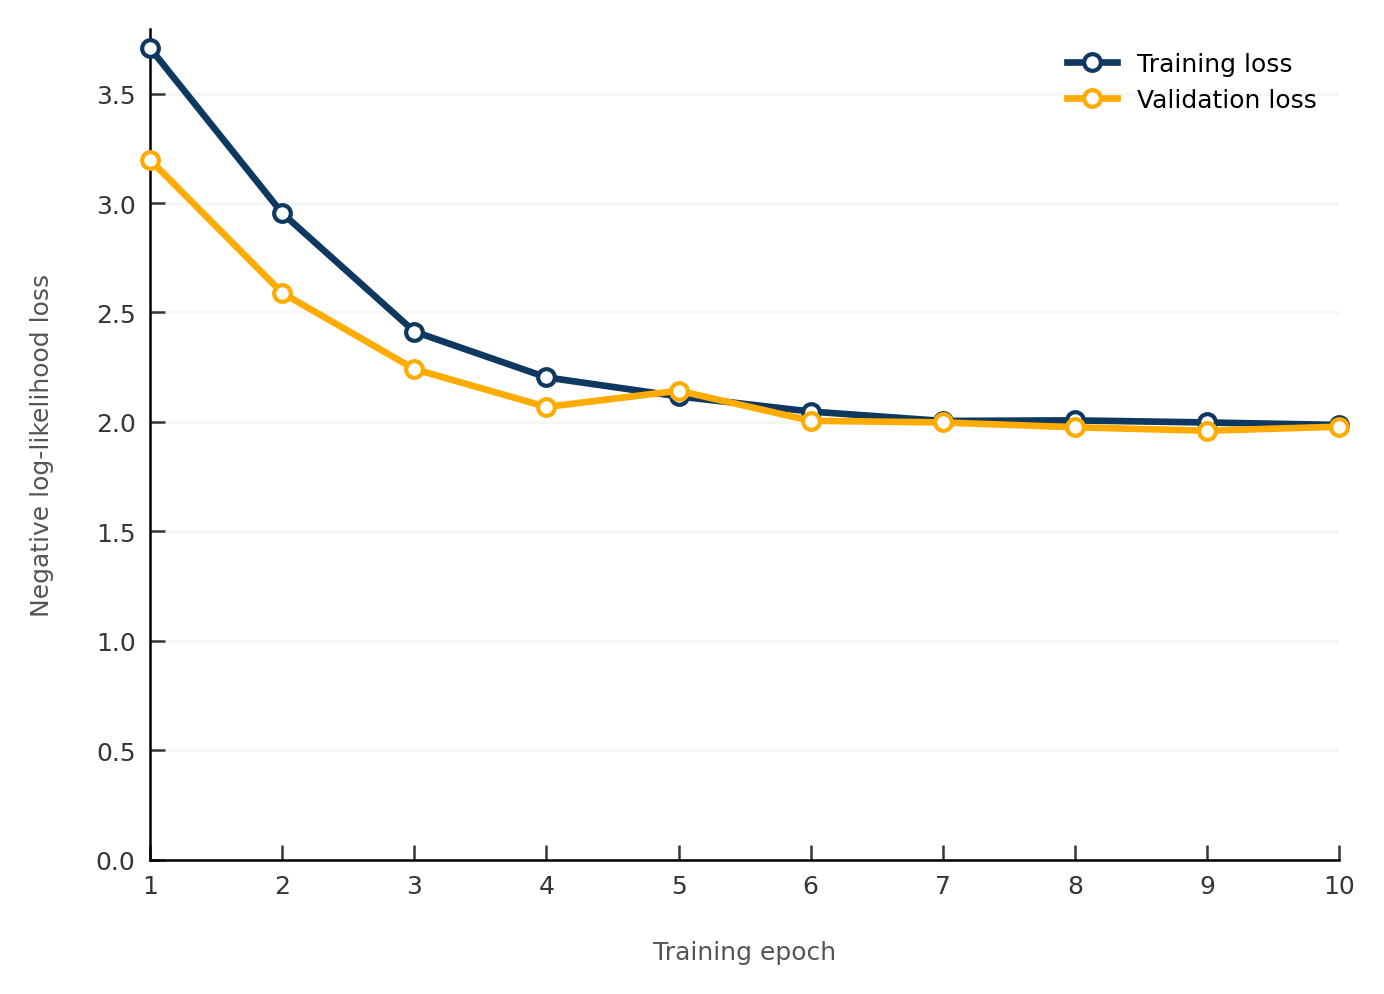

In [ ]:
model_training_log = pd.read_csv(
    sorted(Path("exports").glob("training_log*"))[-1],
    names=(
        "timestamp",
        "epoch",
        "training_batch_loss",
        "validation_batch_loss",
        "model_accuracy",
    )
)
model_training_log

fig, ax = plt.subplots()
for loss_type in (
    "training_batch_loss",
    "validation_batch_loss",
):
    plt.plot(
        model_training_log["epoch"],
        model_training_log[loss_type],
        label=f"{loss_type.replace("_batch_", " ").capitalize()}",
        marker="o",
        markerfacecolor="white",
        clip_on=False,
        zorder=10,
    )
plt.legend(loc="upper right")
plt.ylim(bottom=0)
plt.xlabel("Training epoch")
plt.ylabel("Negative log-likelihood loss")

fig.savefig(Path() / "exports" / "model_training_loss_curve.png")
plt.show()

In [ ]:
%load_ext watermark
%watermark -iv -v -m

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 9.8.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.15.186.el8
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

jiwer     : 4.0.0
librosa   : 0.11.0
matplotlib: 3.10.7
numpy     : 2.3.5
pandas    : 2.3.3
ptitprince: 0.3.1
re        : 2.2.1
requests  : 2.32.5
scipy     : 1.16.3
tqdm      : 4.67.1
whisper   : 20230124

